# Laboratorio #5

**Esteban Zambrano - 22119**<br>
**Edwin Ortega - 22305**<br>
**Diego García - 22404**

### Carga de datos

In [2]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "train.csv", encoding="utf-8", low_memory=False)

print(df.shape)
print(df.columns.tolist())
print(df.isna().mean().round(4))
df.head()

(7613, 5)
['id', 'keyword', 'location', 'text', 'target']
id          0.0000
keyword     0.0080
location    0.3327
text        0.0000
target      0.0000
dtype: float64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# valida que vengan las columnas esperadas
expected = {"id","keyword","location","text","target"}
missing = expected - set(df.columns)
assert not missing, f"Faltan columnas: {missing}"

### Limpieza y preprocesamiento de datos

In [14]:
import re, string, json
import numpy as np
import pandas as pd
from pathlib import Path

KEEP_911 = True
REMOVE_NUMBERS = True
APPLY_STOPWORDS = True

try:
    from nltk.corpus import stopwords
    STOP = set(stopwords.words("english"))
except Exception:
    try:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
        STOP = set(ENGLISH_STOP_WORDS)
    except Exception:
        STOP = set()

if "df" not in globals():
    df = pd.read_csv("data/train.csv")

In [15]:
# Patrones regex y funciones de limpieza

URL_PATTERN     = re.compile(r"http[s]?://\S+|www\.\S+")
HTML_PATTERN    = re.compile(r"<.*?>")
HANDLE_PATTERN  = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")
EMOJI_PATTERN   = re.compile("[" # rangos Unicode de emojis
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F300-\U0001F5FF"  # símbolos
    "\U0001F680-\U0001F6FF"  # transporte/mapas
    "\U0001F1E0-\U0001F1FF"  # banderas
    "]+", flags=re.UNICODE)

def _remove_numbers(text: str) -> str:
    if not REMOVE_NUMBERS:
        return text
    if KEEP_911:
        # elimina números aislados, excepto 911
        return re.sub(r"\b(?!911\b)\d+\b", " ", text)
    # elimina todos los números
    return re.sub(r"\d+", " ", text)

def clean_text_basic(s: str) -> str:
    """
    Pasos: 
      1) minúsculas 
      2) quitar URLs y HTML
      3) quitar @handles y '#', conservando la palabra del hashtag
      4) quitar emojis
      5) quitar números (con opción de conservar 911)
      6) quitar puntuación
      7) colapsar espacios
    """
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)

    x = s.lower()
    x = URL_PATTERN.sub(" ", x)
    x = HTML_PATTERN.sub(" ", x)
    x = HANDLE_PATTERN.sub(" ", x)
    x = HASHTAG_PATTERN.sub(r"\1", x)
    x = EMOJI_PATTERN.sub(" ", x)
    x = _remove_numbers(x)
    x = x.translate(str.maketrans("", "", string.punctuation))
    x = re.sub(r"\s+", " ", x).strip()
    return x

def remove_stopwords(s: str) -> str:
    if not APPLY_STOPWORDS or not STOP:
        return s
    toks = s.split()
    toks = [t for t in toks if t not in STOP]
    return " ".join(toks)

In [16]:
# Aplicar la limpieza y crear clean_text
assert {"text","target"}.issubset(df.columns), "Columnas esperadas no encontradas."

df["clean_text"] = df["text"].map(clean_text_basic).map(remove_stopwords)

# Vista rápida de la limpieza
df[["text", "clean_text"]].head(10)


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent photo ruby alaska smoke wildfire...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,im hill woods
8,There's an emergency evacuation happening now ...,theres emergency evacuation happening building...
9,I'm afraid that the tornado is coming to our a...,im afraid tornado coming area


In [21]:
# Quitar digitos dentro de tokens, preservando '911' como token completo

def strip_digits_preserve_911(text: str) -> str:
    toks = text.split()
    out = []
    for t in toks:
        if t == "911":
            out.append(t)
        else:
            t2 = re.sub(r"\d+", "", t)  # quita dígitos embebidos
            if t2:  # descarta tokens vacíos
                out.append(t2)
    return " ".join(out)

df["clean_text"] = df["clean_text"].map(strip_digits_preserve_911)

# Verificación rápida
rem = df["clean_text"].str.contains(r"\d").sum()
print(f"Filas con dígitos remanentes: {rem}")


Filas con dígitos remanentes: 4


In [22]:
# Reporta filas con dígitos que NO sean el token 911
def has_non911_digits(s: str) -> bool:
    toks = s.split()
    for t in toks:
        if any(ch.isdigit() for ch in t) and t != "911":
            return True
    return False

mask_bad = df["clean_text"].map(has_non911_digits)
print("Filas con dígitos (excluyendo el token '911'):", int(mask_bad.sum()))

# Ver ejemplos si hubiera alguno:
df.loc[mask_bad, ["text","clean_text"]].head(10)


Filas con dígitos (excluyendo el token '911'): 0


,text,clean_text


In [18]:
# Métricas de impacto de la limpieza
stats = {
    "rows": len(df),
    "nulls_pct": df.isna().mean().round(4).to_dict(),
}
lens_before_chars = df["text"].astype(str).str.len().describe().round(2).to_dict()
lens_after_chars  = df["clean_text"].astype(str).str.len().describe().round(2).to_dict()
lens_before_words = df["text"].astype(str).str.split().map(len).describe().round(2).to_dict()
lens_after_words  = df["clean_text"].astype(str).str.split().map(len).describe().round(2).to_dict()

print("Resumen dataset:\n", json.dumps(stats, indent=2))
print("\nLen (caracteres) - antes:\n", json.dumps(lens_before_chars, indent=2))
print("\nLen (caracteres) - después:\n", json.dumps(lens_after_chars, indent=2))
print("\nLen (palabras) - antes:\n", json.dumps(lens_before_words, indent=2))
print("\nLen (palabras) - después:\n", json.dumps(lens_after_words, indent=2))


Resumen dataset:
 {
  "rows": 7613,
  "nulls_pct": {
    "id": 0.0,
    "keyword": 0.008,
    "location": 0.3327,
    "text": 0.0,
    "target": 0.0,
    "clean_text": 0.0
  }
}

Len (caracteres) - antes:
 {
  "count": 7613.0,
  "mean": 101.04,
  "std": 33.78,
  "min": 7.0,
  "25%": 78.0,
  "50%": 107.0,
  "75%": 133.0,
  "max": 157.0
}

Len (caracteres) - después:
 {
  "count": 7613.0,
  "mean": 57.24,
  "std": 24.03,
  "min": 0.0,
  "25%": 40.0,
  "50%": 58.0,
  "75%": 75.0,
  "max": 138.0
}

Len (palabras) - antes:
 {
  "count": 7613.0,
  "mean": 14.9,
  "std": 5.73,
  "min": 1.0,
  "25%": 11.0,
  "50%": 15.0,
  "75%": 19.0,
  "max": 31.0
}

Len (palabras) - después:
 {
  "count": 7613.0,
  "mean": 8.26,
  "std": 3.39,
  "min": 0.0,
  "25%": 6.0,
  "50%": 8.0,
  "75%": 11.0,
  "max": 21.0
}


In [23]:
# Guardar dataset limpio
Path("../data").mkdir(exist_ok=True, parents=True)
df.to_csv("../data/train_clean.csv", index=False)
print("Guardado: ..data/train_clean.csv")

Guardado: ..data/train_clean.csv


| Parámetro / Decisión  | Valor / Descripción                                                                 |
| --------------------- | ----------------------------------------------------------------------------------- |
| KEEP\_911             | `True` → se elimina todo número excepto el token completo `"911"`                   |
| REMOVE\_NUMBERS       | `True` → números eliminados (sueltos o embebidos en palabras)                       |
| APPLY\_STOPWORDS      | `True` → stopwords en inglés eliminadas (NLTK; fallback a scikit-learn si no carga) |
| Minúsculas            | Sí, todo el texto se convierte a minúsculas                                         |
| URLs y HTML           | Eliminados con expresiones regulares                                                |
| @handles              | Eliminados completamente                                                            |
| #hashtags             | Se elimina `#` pero se conserva la palabra (`#wildfire → wildfire`)                 |
| Emojis                | Eliminados (rangos Unicode de emoticones, símbolos, banderas, etc.)                 |
| Signos de puntuación  | Eliminados con `string.punctuation`                                                 |
| Espacios múltiples    | Normalizados a un único espacio                                                     |


### N-gramas por clase

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

assert {"clean_text","target"}.issubset(df.columns), "Falta 'clean_text' o 'target' en df."

TOPK   = 25      # cuántos términos mostrar
MIN_DF = 3       # ignora términos muy raros
STOP   = "english"  # stopwords para CountVectorizer

In [25]:
# Extraer top n-gramas por clase
def top_terms_by_class(texts, y, ngram=(1,1), topk=20, min_df=3, stop_words="english"):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df, stop_words=stop_words)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())

    classes = sorted(pd.Series(y).dropna().unique().tolist())
    rows = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        if len(idx) == 0:
            continue
        freqs = np.asarray(X[idx].sum(axis=0)).ravel()
        order = freqs.argsort()[::-1][:topk]
        for t, f in zip(terms[order], freqs[order]):
            rows.append({"class": int(cls), "term": t, "freq": int(f)})

    out = pd.DataFrame(rows).sort_values(["class", "freq"], ascending=[True, False])
    return out


In [26]:
# Unigramas
uni_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(1,1), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(uni_df.head(2*TOPK))

# Bigramas
bi_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(2,2), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(bi_df.head(2*TOPK))

Path("../reports").mkdir(exist_ok=True, parents=True)
uni_df.to_csv("../reports/top_unigrams_by_class.csv", index=False)
bi_df.to_csv("../reports/top_bigrams_by_class.csv", index=False)
print("Guardados:\n  ../reports/top_unigrams_by_class.csv\n  ../reports/top_bigrams_by_class.csv")


,class,term,freq
0,0,like,253
1,0,im,244
2,0,just,234
3,0,amp,193
4,0,new,170
5,0,dont,141
6,0,body,113
7,0,video,96
8,0,people,90
9,0,love,89


,class,term,freq
0,0,cross body,38
1,0,liked video,34
2,0,body bag,27
3,0,burning buildings,23
4,0,body bagging,23
5,0,reddit quarantine,21
6,0,looks like,21
7,0,body bags,21
8,0,content policy,20
9,0,feel like,20


Guardados:
  ../reports/top_unigrams_by_class.csv
  ../reports/top_bigrams_by_class.csv


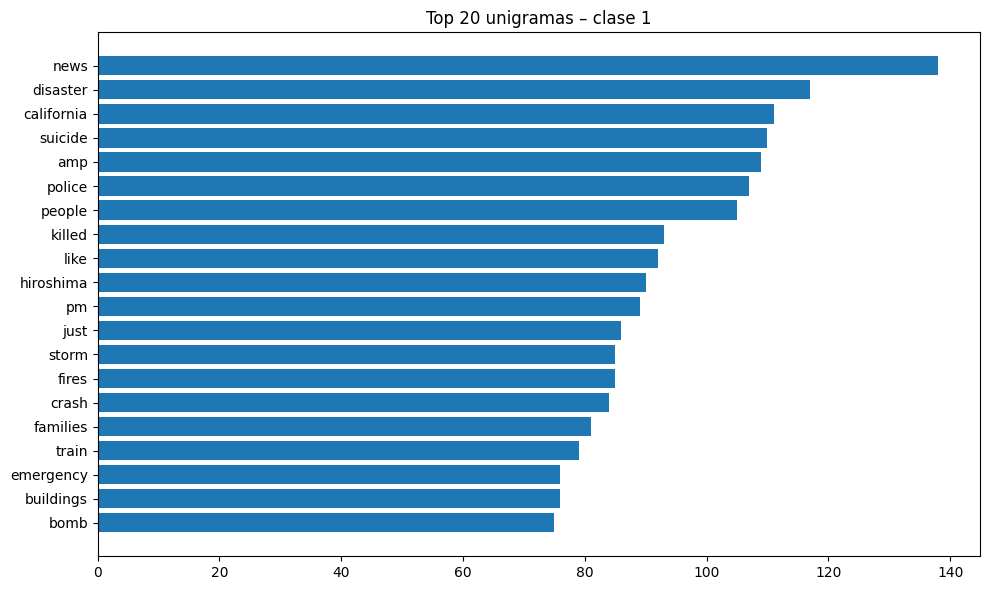

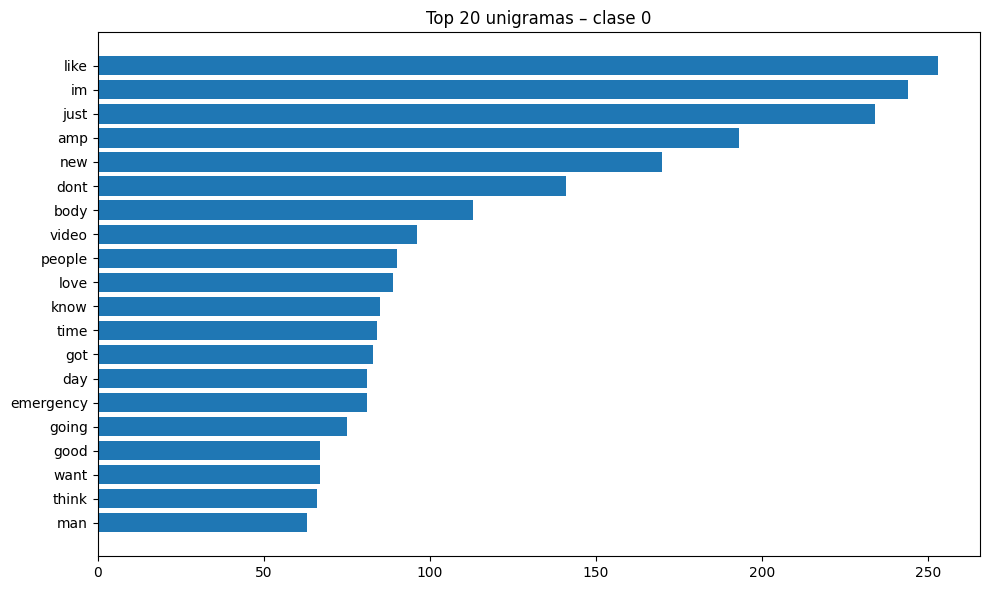

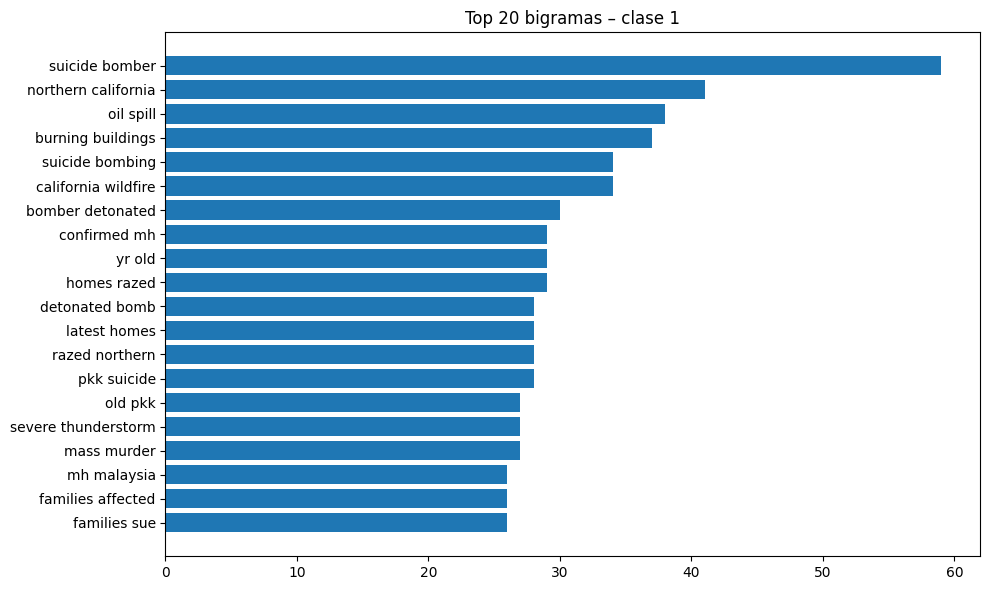

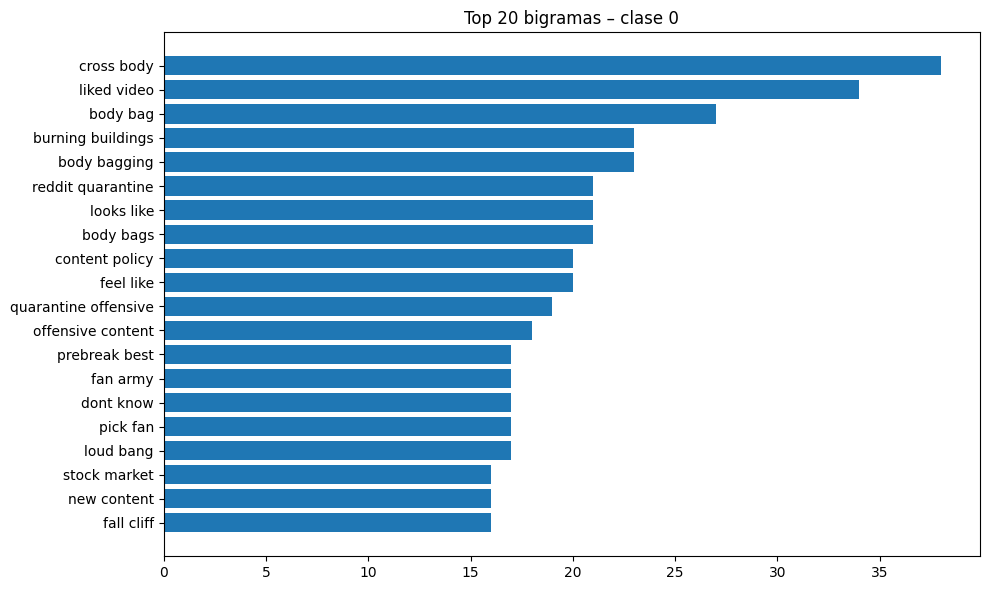

In [27]:
# Barras horizontales por clase
def plot_top_bar(df_terms, cls, title_suffix, topk=20):
    data = df_terms[df_terms["class"]==cls].head(topk).iloc[::-1]
    if data.empty:
        print(f"Clase {cls}: sin términos para graficar.")
        return
    plt.figure(figsize=(10, 6))
    plt.barh(data["term"], data["freq"])  # no especificar colores
    plt.title(f"Top {len(data)} {title_suffix} – clase {cls}")
    plt.tight_layout()
    plt.show()

# Unigramas
plot_top_bar(uni_df, 1, "unigramas", topk=20)
plot_top_bar(uni_df, 0, "unigramas", topk=20)

# Bigramas
plot_top_bar(bi_df,  1, "bigramas",  topk=20)
plot_top_bar(bi_df,  0, "bigramas",  topk=20)
